In [1]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge geocoder --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge


In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import re
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

font = {'size'   : 14}
mpl.rc('font', **font)

# Use Folium to display the Maps for Visualisation
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins
from folium.plugins import HeatMap


#### Visualize crime data

In [4]:
# load crime data, grep  a particular borough
dfc=pd.read_csv("berlincrime2018.csv",index_col = 0)
sw_data = dfc[dfc['Borough'] == 'Charlottenburg-Wilmersdorf'].reset_index(drop=True)
sw_data.drop(sw_data.tail(1).index,inplace=True)
sw_n=sw_data['Neighborhood'].to_list()
sw_data.drop(columns=['Borough'], inplace=True)
sw_data.set_index('Neighborhood', inplace=True)
sw_data.head(3)

,Total records,Robbery,Street robbery,Total physical injury,Serious bodily harm,Coercion,Total theft,Bicycle theft,Burglary,Property damage,Drug offenses
Neighborhood,,,,,,,,,,,
Charlottenburg-Nord,2532,23,6,279,84,107,1030,123,51,232,185
Heerstrasse,1530,16,9,178,64,39,656,75,89,139,49
Westend,3915,25,16,318,83,119,2188,213,79,243,45


In [5]:
sw_data.describe()

,Total records,Robbery,Street robbery,Total physical injury,Serious bodily harm,Coercion,Total theft,Bicycle theft,Burglary,Property damage,Drug offenses
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,2957.823529,22.823529,10.529412,232.058824,57.647059,77.647059,1448.529412,199.117647,54.882353,204.705882,57.117647
std,2040.883058,15.371383,8.024320,173.368636,50.323878,42.443994,1046.435564,127.899806,28.159995,112.038924,50.730763
min,105.000000,4.000000,1.000000,22.000000,3.000000,6.000000,32.000000,1.000000,0.000000,9.000000,0.000000
25%,1634.000000,12.000000,4.000000,130.000000,25.000000,39.000000,793.000000,123.000000,33.000000,108.000000,18.000000
50%,2441.000000,18.000000,9.000000,216.000000,58.000000,78.000000,1062.000000,179.000000,52.000000,222.000000,49.000000
75%,4094.000000,33.000000,15.000000,282.000000,64.000000,107.000000,2188.000000,269.000000,75.000000,259.000000,65.000000
max,8120.000000,62.000000,31.000000,760.000000,218.000000,154.000000,4351.000000,471.000000,107.000000,399.000000,185.000000


Text(0.0, 1.0, 'Count of Cases per Neighborhood')

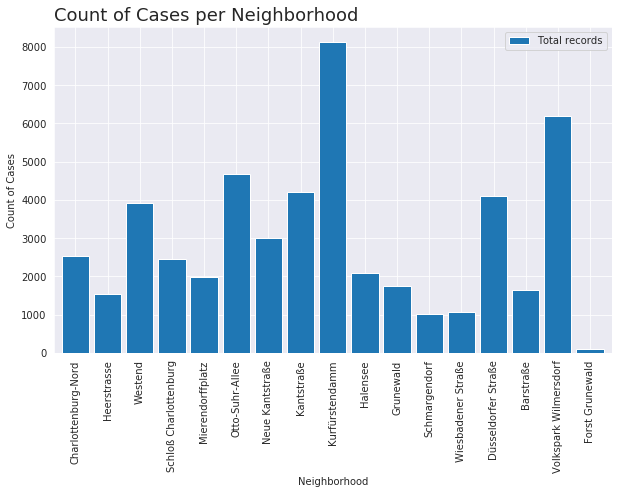

In [6]:
# display different statistics: crimes/rental costs/avarage school grade
#  for a particular borough Charlottenburg-Wilmersdorf, produce a bar chart
sw_data.plot(y = 'Total records', kind='bar', figsize=(10,6),
             width=0.85, colormap='tab20')

plt.xlabel('Neighborhood')
plt.ylabel('Count of Cases')
plt.title('Count of Cases per Neighborhood', loc='left', fontsize=18)

In [7]:
swt=sw_data.drop(columns=['Total records']).T
print(swt.shape)
swt.head(3)

(10, 17)


Neighborhood,Charlottenburg-Nord,Heerstrasse,Westend,Schloß Charlottenburg,Mierendorffplatz,Otto-Suhr-Allee,Neue Kantstraße,Kantstraße,Kurfürstendamm,Halensee,Grunewald,Schmargendorf,Wiesbadener Straße,Düsseldorfer Straße,Barstraße,Volkspark Wilmersdorf,Forst Grunewald
Robbery,23,16,25,18,7,38,33,38,62,13,12,4,10,40,15,27,7
Street robbery,6,9,16,10,3,20,19,15,31,4,5,1,3,15,5,13,4
Total physical injury,279,178,318,282,158,445,252,284,760,136,89,60,94,242,130,216,22


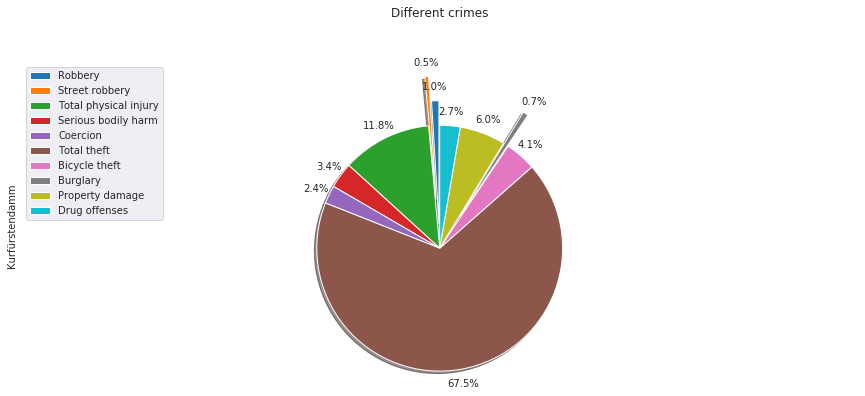

In [8]:
# pie diagramm for Kurfürstendamm
explode_list = [0.2,0.4,0,0,0,0,0,0.3,0,0] # ratio for each continent with which to offset each wedge.
swt['Kurfürstendamm'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,                 # turn off labels on pie chart
                            pctdistance=1.12,            # the ratio between the pie center and start of text label
                            explode=explode_list         # 'explode' lowest 3 continents
                            )
# scale the title up by 12% to match pctdistance
plt.title('Different crimes', y=1.12) 
plt.axis('equal') 
 # add legend
plt.legend(labels=swt.index, loc='upper left') 
# show plot
plt.show()

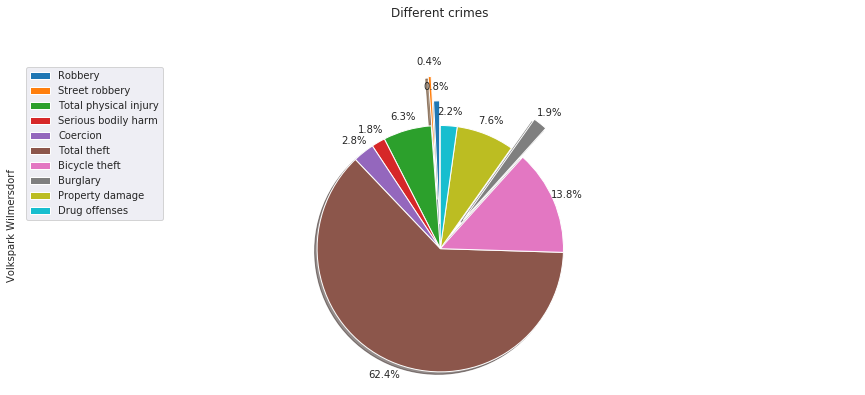

In [9]:
# pie diagramm Volkspark Wilmersdorf
explode_list = [0.2,0.4,0,0,0,0,0,0.3,0,0] # ratio for each continent with which to offset each wedge.
swt['Volkspark Wilmersdorf'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,                 # turn off labels on pie chart
                            pctdistance=1.12,            # the ratio between the pie center and start of text label
                            explode=explode_list         # 'explode' lowest 3 continents
                            )
# scale the title up by 12% to match pctdistance
plt.title('Different crimes', y=1.12) 
plt.axis('equal') 
 # add legend
plt.legend(labels=swt.index, loc='upper left') 
# show plot
plt.show()

In [10]:
files='berlincrime' + str(2012)+'.csv'
years=[]
df0=pd.read_csv("berlincrime2018.csv",index_col = 0)
df1 = df0[df0['Borough'] == 'Charlottenburg-Wilmersdorf'].reset_index(drop=True)
df1.drop(df1.tail(1).index,inplace=True)
l1= df1['Neighborhood'].to_list()
l2=df1['Total records'].to_list()
years.append(2012)
df2= pd.DataFrame(
    {'Neighborhood': l1,
     'Year 2012': l2
    })
df2.head(3)

,Neighborhood,Year 2012
0,Charlottenburg-Nord,2532
1,Heerstrasse,1530
2,Westend,3915


In [11]:
# load crime data, grep  a particular borough, create a data frame with a total records per year
for  year in range (2013,2019):
    files='berlincrime' + str(year)+'.csv'
    print(files)
    df0=pd.read_csv(files,index_col = 0)
    df1 = df0[df0['Borough'] == 'Charlottenburg-Wilmersdorf'].reset_index(drop=True)
    df1.drop(df1.tail(1).index,inplace=True)
    l2=df1['Total records'].to_list()
    cname='Year ' +str(year)
    years.append(year)
    df2[cname]=l2
#sw_data.drop(columns=['Borough'], inplace=True)
df2.set_index('Neighborhood', inplace=True)
df2.head(3)

berlincrime2013.csv
berlincrime2014.csv
berlincrime2015.csv
berlincrime2016.csv
berlincrime2017.csv
berlincrime2018.csv


,Year 2012,Year 2013,Year 2014,Year 2015,Year 2016,Year 2017,Year 2018
Neighborhood,,,,,,,
Charlottenburg-Nord,2532,2730,2913,2945,3169,2846,2532
Heerstrasse,1530,1425,1448,2099,1474,1352,1530
Westend,3915,3977,4659,4777,4843,4448,3915


In [12]:
#df2T.describe()
totl=df2.loc['Kurfürstendamm'] # Pandas series
df_tot =pd.DataFrame(
    {'year': years,
     'total': totl.to_list()
    })

# view the final dataframe
df2.to_pickle("crimeprediction_cw.pkl")
df_tot.head(3)

,year,total
0,2012,8120
1,2013,8737
2,2014,9932


Text(0.5, 1.0, 'Total crime records for Kurfürstendamm from 2012 - 2018')

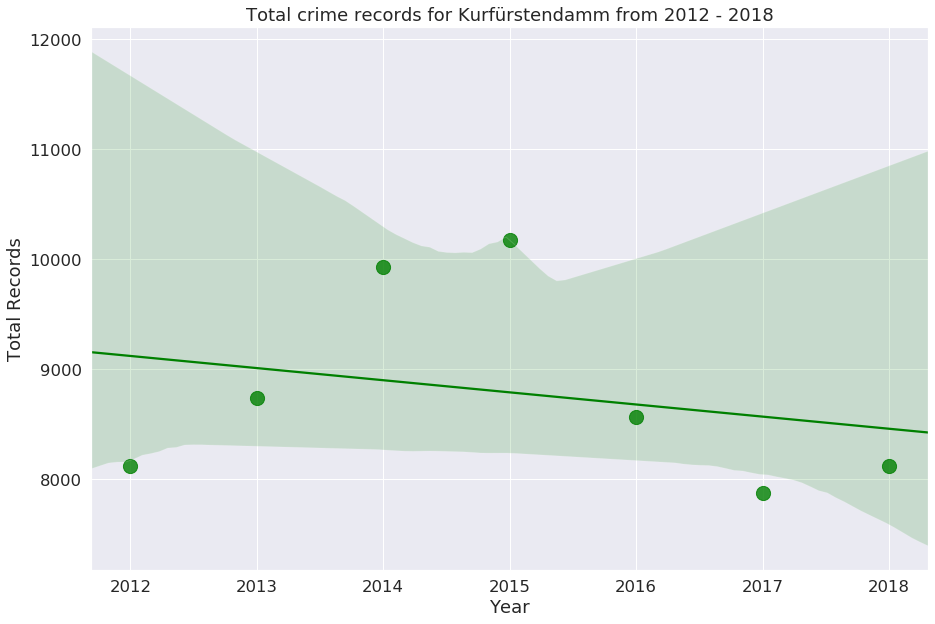

In [13]:
import seaborn as sns
# simple regression plot
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
#sns.set_style('ticks') # change background to white background
ax = sns.regplot(x='year', y='total', data=df_tot, color='green', scatter_kws={'s': 200})
ax.set(xlabel='Year', ylabel='Total Records')
ax.set_title('Total crime records for Kurfürstendamm from 2012 - 2018')

Text(0.5, 1.0, 'Total crime records for Kurfürstendamm from 2012 - 2018')

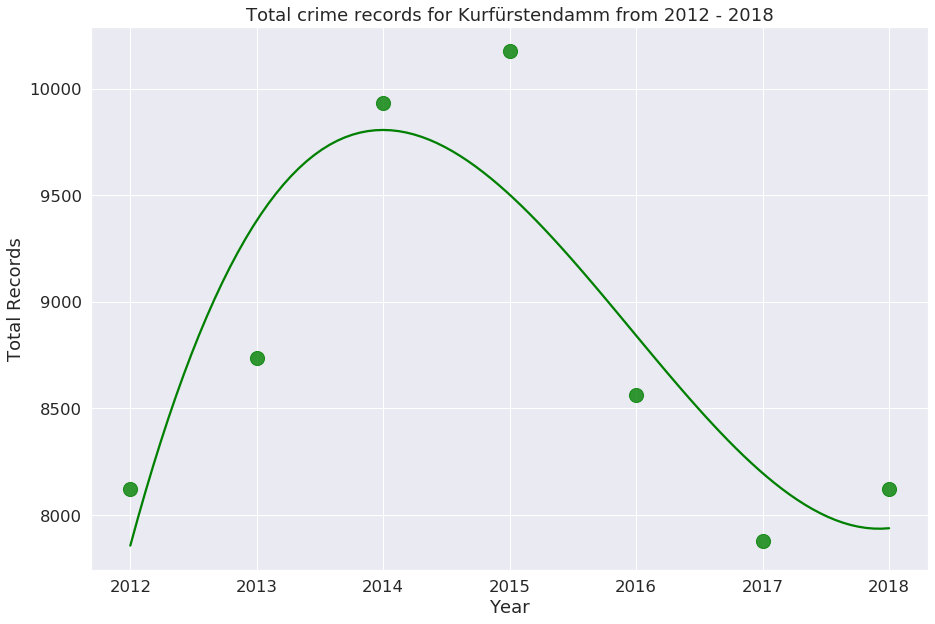

In [14]:
# polinomial fit of the thierd order 
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.5)
ax = sns.regplot(x='year', y='total', data=df_tot, color='green',  scatter_kws={'s': 200}, \
                 order=3, ci=None, truncate=True)
ax.set(xlabel='Year', ylabel='Total Records')
ax.set_title('Total crime records for Kurfürstendamm from 2012 - 2018')

In [15]:
from folium.plugins import HeatMap
cw_long=[13.296100,13.262060,13.259810,13.296390,13.304730,13.310560,13.283700,13.314350,13.318910,13.295690,\
         13.265800,13.290050,13.309510,13.316530,13.314760,13.325950,13.265800]
cw_lati=[52.530450,52.505060,52.516200,52.515160,52.525690,52.516230,52.506410,52.506210,52.501630,52.495970,\
         52.483380,52.475800,52.472370,52.496440,52.485470,52.482790,52.483380]
cw_crim=df2['Year 2018'].to_list()
# take a cw borough
print(len(cw_long), df2.shape)
df_crime=pd.DataFrame(
    {'X': cw_lati,
     'Y': cw_long,
     'Records': cw_crim,
     'Name': sw_n
    })
df_crime.head(3)

17 (17, 7)


,X,Y,Records,Name
0,52.53045,13.29610,2532,Charlottenburg-Nord
1,52.50506,13.26206,1530,Heerstrasse
2,52.51620,13.25981,3915,Westend


In [16]:
latitude=52.500000
longitude=13.283333
  
# Creating a map object using Map() function. 
# Location parameter takes latitudes and  
map5 = folium.Map(location=[latitude,longitude], 
        zoom_start=12) 
          
# Function to change the marker color  according to the total count
def color(elev): 
    if elev in range(0,2000): 
        col = 'green'
    elif elev in range(2001,3999): 
        col = 'blue'
    elif elev in range(4000,5999): 
        col = 'orange'
    else: 
        col='red'
    return col 
      
# Iterating over the lat, lon, name and elev columns simultaneously using zip()
for lat,lan,name,elev in zip(df_crime['X'],df_crime['Y'],df_crime['Name'],df_crime['Records']): 
    # Marker() takes location coordinates  
    # as a list as an argument 
    folium.Marker(location=[lat,lan],popup = name, 
                  icon= folium.Icon(color=color(elev), 
                  icon_color='yellow',icon = 'cloud')).add_to(map5) 
map5

#### Visualize school data

In [17]:
dfpl=pd.read_csv("berlin_neighb_coords.csv",index_col = 0)
dfpl.head(3)

,Borough,Neighborhood,Postcode,Longitude,Latitude
0,Mitte,Mitte,10115,13.387224,52.533707
1,Pankow,PrenzlauerBerg,10119,13.407149,52.532666
2,Friedrichshain-Kreuzberg,Friedrichshain,10243,13.441956,52.514918


In [18]:
dfs=pd.read_csv('berlinschool2019.csv',index_col = 0)
dfs.head(3)

,Postcode,Neighborhood,Grade
0,12359,Britz,2.30
1,12043,Neukölln,2.63
2,12051,Neukölln,2.60


In [19]:
resul = pd.merge(dfs, dfpl, on=['Postcode'])
resul.head(3)

,Postcode,Neighborhood_x,Grade,Borough,Neighborhood_y,Longitude,Latitude
0,10243,Friedrichshain,2.55,Friedrichshain-Kreuzberg,Friedrichshain,13.441956,52.514918
1,10243,Friedrichshain,2.28,Friedrichshain-Kreuzberg,Friedrichshain,13.441956,52.514918
2,12524,Altglienicke,2.41,Treptow-Köpenick,Altglienicke,13.543996,52.415364


In [20]:
sc_data = resul[resul['Borough'] == 'Charlottenburg-Wilmersdorf'].reset_index(drop=True)
#sc_data.drop(sx_data.tail(1).index,inplace=True)
sc_data.drop(columns=['Neighborhood_x'], inplace=True)
sc_data.rename(columns={'Neighborhood_y': 'Neighborhood'}, inplace=True)
sc_data.head(3)

,Postcode,Grade,Borough,Neighborhood,Longitude,Latitude
0,10589,2.75,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,13.308494,52.529399
1,14193,2.28,Charlottenburg-Wilmersdorf,Schmargendorf,13.232888,52.476342
2,14193,2.51,Charlottenburg-Wilmersdorf,Schmargendorf,13.232888,52.476342


In [21]:
Schmargendorf_Latitude=52.475800
Schmargendorf_Longitude=13.290050
sc_data.loc[sc_data['Neighborhood'] == 'Schmargendorf', 'Latitude'] = Schmargendorf_Latitude
sc_data.loc[sc_data['Neighborhood'] == 'Schmargendorf', 'Longitude'] = Schmargendorf_Longitude
sc_data.to_pickle("schools_cw.pkl")
sc_data.head(3)

,Postcode,Grade,Borough,Neighborhood,Longitude,Latitude
0,10589,2.75,Charlottenburg-Wilmersdorf,Charlottenburg-Nord,13.308494,52.529399
1,14193,2.28,Charlottenburg-Wilmersdorf,Schmargendorf,13.290050,52.475800
2,14193,2.51,Charlottenburg-Wilmersdorf,Schmargendorf,13.290050,52.475800


In [22]:
def generateBaseMap(default_location=[52.500000,13.283333], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale = True, zoom_start=default_zoom_start)
    return base_map

In [23]:
cw_scgrade=sc_data['Grade'].to_list()
cw_sclon=sc_data['Longitude'].to_list()
cw_sclat=sc_data['Latitude'].to_list()
# create map of CW using latitude and longitude values
latitude=52.500000
longitude=13.283333
data=[]

cw_scgrade=(cw_scgrade - np.mean(cw_scgrade))/np.std(cw_scgrade)*100
for i in range(len(cw_sclon)):
    data.append([cw_sclat[i],cw_sclon[i],cw_scgrade[i]])

base_map = generateBaseMap()
HeatMap(data,radius = 50, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, \
        min_opacity=0.6).add_to(base_map)

for lan,lat,name in zip(sc_data['Longitude'],sc_data['Latitude'],sc_data['Neighborhood']):
    folium.Marker(location=[lat,lan],icon= folium.Icon(color='lightgray',icon_color='yellow',icon='graduation-cap', prefix='fa'), \
                  popup = name).add_to(base_map)

#base_map.add_child(folium.ClickForMarker(popup='Potential Location'))
# display map
base_map

#### Visualize rental costs data

In [24]:
dfrc=pd.read_csv("berlinrenatlcosts2019.csv",index_col = 0)
dfrc.head(3)

,Neighborhood,Rental costs
0,Adlershof,12.51
1,Alt-Hohenschönhausen,10.76
2,Alt-Treptow,12.90


In [25]:
resul2 = pd.merge(dfrc, dfpl, on=['Neighborhood'])
resul2.head(3)

,Neighborhood,Rental costs,Borough,Postcode,Longitude,Latitude
0,Adlershof,12.51,Treptow-Köpenick,12487,13.512303,52.443761
1,Alt-Hohenschönhausen,10.76,Lichtenberg,13051,13.497783,52.579643
2,Alt-Treptow,12.90,Treptow-Köpenick,12435,13.469581,52.489270


In [26]:
sr_data = resul2[resul2['Borough'] == 'Charlottenburg-Wilmersdorf'].reset_index(drop=True)
sr_data.head(6)

,Neighborhood,Rental costs,Borough,Postcode,Longitude,Latitude
0,Charlottenburg,15.61,Charlottenburg-Wilmersdorf,10585,13.307670,52.516531
1,Grunewald,16.53,Charlottenburg-Wilmersdorf,10711,13.294385,52.499381
2,Halensee,14.94,Charlottenburg-Wilmersdorf,10709,13.306143,52.495449
3,Schmargendorf,14.34,Charlottenburg-Wilmersdorf,14193,13.232888,52.476342
4,Westend,13.20,Charlottenburg-Wilmersdorf,14050,13.270889,52.523177
5,Wilmersdorf,14.71,Charlottenburg-Wilmersdorf,10707,13.317009,52.498305


In [27]:
Grunewald_Latitude=52.483379
Grunewald_Longitude=13.265800
sr_data.loc[sr_data['Neighborhood'] == 'Schmargendorf', 'Latitude'] = Schmargendorf_Latitude
sr_data.loc[sr_data['Neighborhood'] == 'Schmargendorf', 'Longitude']= Schmargendorf_Longitude
sr_data.loc[sr_data['Neighborhood'] == 'Grunewald', 'Latitude'] = Grunewald_Latitude
sr_data.loc[sr_data['Neighborhood'] == 'Grunewald', 'Longitude']= Grunewald_Longitude
sr_data.loc[sr_data['Neighborhood'] == 'Westend', 'Latitude'] = 52.516201
sr_data.loc[sr_data['Neighborhood'] == 'Westend', 'Longitude']=  13.259810
sr_data.loc[sr_data['Neighborhood'] == 'Halensee', 'Latitude'] = 52.495972
sr_data.loc[sr_data['Neighborhood'] == 'Halensee', 'Longitude']=  13.295690
sr_data.loc[sr_data['Neighborhood'] == 'Wilmersdorf', 'Latitude'] = 52.482980
sr_data.loc[sr_data['Neighborhood'] == 'Wilmersdorf', 'Longitude']=  13.320370
sr_data.to_pickle("rentals_cw.pkl")
sr_data.head(6)

,Neighborhood,Rental costs,Borough,Postcode,Longitude,Latitude
0,Charlottenburg,15.61,Charlottenburg-Wilmersdorf,10585,13.30767,52.516531
1,Grunewald,16.53,Charlottenburg-Wilmersdorf,10711,13.26580,52.483379
2,Halensee,14.94,Charlottenburg-Wilmersdorf,10709,13.29569,52.495972
3,Schmargendorf,14.34,Charlottenburg-Wilmersdorf,14193,13.29005,52.475800
4,Westend,13.20,Charlottenburg-Wilmersdorf,14050,13.25981,52.516201
5,Wilmersdorf,14.71,Charlottenburg-Wilmersdorf,10707,13.32037,52.482980


In [28]:
from folium.plugins import FloatImage
url = ('https://raw.githubusercontent.com/SECOORA/static_assets/'
       'master/maps/img/rose.png')

cw_srent=sr_data['Rental costs'].to_list()
cw_sclon=sr_data['Longitude'].to_list()
cw_sclat=sr_data['Latitude'].to_list()

# create map of Berlin-Mitte using latitude and longitude values
latitude=52.500000
longitude=13.283333
cw_srent= (cw_srent - np.mean(cw_srent))/np.std(cw_srent)*1000
data=[]
for i in range(len(cw_sclon)):
    data.append([cw_sclat[i],cw_sclon[i],cw_srent[i]])
    
base_map2 = generateBaseMap()
HeatMap(data,radius = 30,gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, \
        min_opacity=0.5).add_to(base_map2)
#FloatImage(url, bottom=4, left=5).add_to(base_map2) 

for lan,lat,name in zip(sr_data['Longitude'],sr_data['Latitude'],sr_data['Neighborhood']):
    folium.Marker(location=[lat,lan],icon= folium.Icon(color='lightgray',icon_color='yellow',icon='home', prefix='fa'), \
                  popup = name).add_to(base_map2)
    

# display map
base_map2

#### Visualize the venue data

In [29]:
CLIENT_ID = '*' # your Foursquare ID
CLIENT_SECRET = '*' # your Foursquare Secret
VERSION = '20180604'
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

# coordinates of Charlottenburg-Wilmersdorf
neighborhood_latitude  = 52.500000  # neighborhood latitude value
neighborhood_longitude = 13.283333 # neighborhood longitude valu

In [30]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [31]:
# create the GET request URL. 
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url # display URL
results = requests.get(url).json()

In [32]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Lietzenseepark,Park,52.504977,13.287041
1,Cups,Café,52.497388,13.291307
2,Fressnapf,Pet Store,52.499663,13.288616
3,Fleischerei Bünger,Butcher,52.496390,13.292842
4,Aspria Berlin Ku'damm,Hotel,52.500597,13.294459


In [33]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))
nearby_venues.to_pickle("nearby_venues_sw.pkl")

65 venues were returned by Foursquare.


In [34]:
cw_data=pd.DataFrame(
    {'Latitude': cw_lati,
     'Longitude': cw_long,
     'Borough': 'Charlottenburg-Wilmersdorf',
     'Neighborhood': sw_n
    })
cw_data.head()
cw_data.to_pickle("cw_data.pkl")

In [35]:
# create map of CW using latitude and longitude values
map_cw = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(cw_data['Latitude'],cw_data['Longitude'],cw_data['Borough'],cw_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cw)  
    
map_cw

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
# create a new dataframe called cw_venues
cw_venues = getNearbyVenues(names= cw_data['Neighborhood'],
                                   latitudes=cw_data['Latitude'],
                                   longitudes=cw_data['Longitude']
                                  )

Charlottenburg-Nord
Heerstrasse
Westend
Schloß Charlottenburg
Mierendorffplatz
Otto-Suhr-Allee
Neue Kantstraße
Kantstraße
Kurfürstendamm
Halensee
Grunewald
Schmargendorf
Wiesbadener Straße
Düsseldorfer Straße
Barstraße
Volkspark Wilmersdorf
Forst Grunewald


In [38]:
# check the size of the resulting dataframe
print(cw_venues.shape)
cw_venues.head()
cw_venues.to_pickle("cw_venues.pkl")

(506, 7)


In [39]:
# check how many venues were returned for each neighborhood
cw_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Barstraße,16,16,16,16,16,16
Charlottenburg-Nord,6,6,6,6,6,6
Düsseldorfer Straße,54,54,54,54,54,54
Forst Grunewald,10,10,10,10,10,10
Grunewald,10,10,10,10,10,10
Halensee,32,32,32,32,32,32
Heerstrasse,8,8,8,8,8,8
Kantstraße,62,62,62,62,62,62
Kurfürstendamm,100,100,100,100,100,100


In [40]:
# find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(cw_venues['Venue Category'].unique())))

There are 122 uniques categories.


In [41]:
dfcoun=cw_venues.groupby('Neighborhood').count()
dfcoun.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Barstraße,16,16,16,16,16,16
Charlottenburg-Nord,6,6,6,6,6,6
Düsseldorfer Straße,54,54,54,54,54,54
Forst Grunewald,10,10,10,10,10,10
Grunewald,10,10,10,10,10,10


Text(0.0, 1.0, 'Count of Venues per Neighborhood')

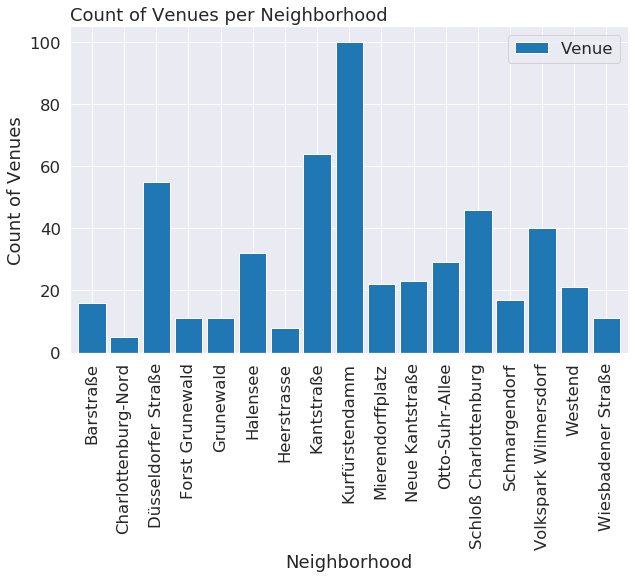

In [77]:
# display venues
dfcoun.plot(y = 'Venue', kind='bar', figsize=(10,6),
             width=0.85, colormap='tab20')

plt.xlabel('Neighborhood')
plt.ylabel('Count of Venues')
plt.title('Count of Venues per Neighborhood', loc='left', fontsize=18)